In [1]:
from keras.models import load_model
from skimage.io import imread
import numpy as np
import keras.backend as K
K.set_image_data_format('channels_last')
import os
import matplotlib.pyplot as plt
import malis as m
from malis.malis_keras import malis_loss2d

# load test data
path = "..."
test_image_files = os.listdir(os.path.join(path + "/test/image"))
print(test_image_files)

# loading trained model: 
# modelm for model trained with malis loss
# modelc for model trained with cross entropy loss
modelm = load_model('.../malis_model.h5',custom_objects={'MALIS_loss':malis_loss2d})
modelc = load_model('.../ce_model.h5')

raw = []   # input test data
predm =[]  # predicted images with malis loss
predc = [] # predicted images with cross entropy loss
gt=[]      # groundtruth

for im in test_image_files:
    img = imread(path+'/test/image/'+im)/255.
    groundtruth_data = imread(path + '/test/groundtruth/'+im)
    for i in range(2):
        for j in range(2):
            x = img[np.newaxis,i*512:i*512+512,j*512:j*512+512,:]
            gt.append(groundtruth_data[i*512:i*512+512,j*512:j*512+512])

            Y_predm = modelm.predict(x)
            Y_predc = modelc.predict(x)
                       
            raw.append(x)
            predm.append(Y_predm)
            predc.append(Y_predc)

print('loading test images:', len(predm))

Using TensorFlow backend.
Using TensorFlow backend.


['200-12b_20000_11.tif-seg.tif', '377-12b_20000_2.tif-seg.tif', '154-12b_20000_14.tif-seg.tif']
['200-12b_20000_11.tif-seg.tif', '377-12b_20000_2.tif-seg.tif', '154-12b_20000_14.tif-seg.tif']
loading test images: 12
loading test images: 12


In [2]:
# evaluation criteria

def object_segmentation(seg, gt):
    """     
    This evaluation criteria is based on counting the number of correctly 
    segmented objects (Dice coefficient > 70 %), divided by the average of 
    total number of ground-truth objects.

    Input:
        seg: list
           List of segmentation images (batch,H,W,C)
        gt: list
           List of groundtruths (H,W)
    Returns:
        score: scale
           The score of this criteria
    """
    from skimage.measure import label
    from collections import Counter
    from skimage import morphology
        
    seg = label(morphology.remove_small_objects(label(seg), 64))    
    groundtruth = label(morphology.remove_small_objects(label(np.expand_dims(gt,axis=-1)), 64))

    dice = []
    label_list = []

    for value in range(1,np.max(groundtruth)+1):

        tmpgt = np.copy(groundtruth)
        tmpgt = np.where(tmpgt == value,1,0)

        tmpseg = np.copy(seg)
        seg_label = Counter(tmpseg[groundtruth == value]).most_common(1)[0][0] # find the most common class in the crossponding areas
        if seg_label in label_list:   # if several objects are connected in the segmentation images, they are considered as wrongly segmented objects
            diceseg = 0
            index = label_list.index(seg_label)
            dice[index] = 0
        else:
            tmpseg = np.where(tmpseg == seg_label,1,0)
            diceseg = np.sum(tmpseg[tmpgt == 1])*2/float(np.sum(tmpseg) + np.sum(tmpgt))
        label_list.append(seg_label)
        dice.append(diceseg)
    
    score = sum(1 for i in dice if i > 0.7)/len(dice) # counting dice > 70%
    return score

In [3]:
# optimal threshold scheme

def find_threshold(pred_aff, gt):
    """
    This function aims to automatically find an optimal threshold, 
    converting the predicted affinity graphs to the segmentation images, 
    to achive the highest score of the given evaluation indices. 
     
    The evaluation criteria used here is object segmentation.

    Input:
        pred_aff: list
           List of predicted affinity graphs (batch,H,W,C)
        gt: list
           List of crossponding groundtruths (H,W)
    Returns:
        opt_threshold: scale
           The optimal threshold
        result: scale
           The highest score with the given evaluation criteria
        output_seg: list
           List of segmentation images with the optimal threshold
    """
    from scipy.ndimage.morphology import binary_fill_holes

    result = 0
    opt_threshold = 0

    for threshold in np.arange(0.1, 1.0, 0.01):
        segmalis_dice = []
        final_seg = []
        for patch in range(len(pred_aff)):
            nhood = m.mknhood3d(1)[:-1]
            aff = np.transpose(np.expand_dims(np.where(pred_aff[patch][0]<threshold,0,1),axis=0),(3,1,2,0))
            seg = m.affgraph_to_seg(aff.astype(np.int32),nhood)     # obtain segmentation from predicted affinity graphs
            seg = np.where(seg==0,0,1)
            seg = np.expand_dims(binary_fill_holes(seg[:,:,0]).astype(int),axis=-1)  # fill small holes in the isntances
            final_seg.append(seg)
            
            segmalis_dice.append(object_segmentation(seg, gt[patch]))  # could be changed to other indices
            
        if sum(segmalis_dice)/len(segmalis_dice) > result:
            result = sum(segmalis_dice)/len(segmalis_dice)
            opt_threshold = threshold
            output_seg = final_seg
                
    return opt_threshold, result, output_seg
        
opt_threshold, result, output_seg = find_threshold(predm, gt)
print('Optimal threshold:',opt_threshold)
print('The highest score of object segmentation indices for malis loss:',result)

/home/haicu/ruolin.shen/anaconda3/envs/malis/lib/python3.7/site-packages/ipykernel_launcher.py:22: UserWarning: Only one label was provided to `remove_small_objects`. Did you mean to use a boolean array?
/home/haicu/ruolin.shen/anaconda3/envs/malis/lib/python3.7/site-packages/ipykernel_launcher.py:22: UserWarning: Only one label was provided to `remove_small_objects`. Did you mean to use a boolean array?


Optimal threshold: 0.6599999999999997
The highest score of object segmentation indices for malis loss: 0.7324106449106448
Optimal threshold: 0.6599999999999997
The highest score of object segmentation indices for malis loss: 0.7324106449106448


In [8]:
# check the indices scores of cross entropy loss
ce = []
ce_dice = []
for patch in range(len(predm)):

    prediction = predc[patch][0]
    pred_mean = np.mean(prediction)
    prediction[prediction <= pred_mean] = 0
    prediction[prediction > pred_mean] = 1
    ce.append(prediction)
    
    ce_dice.append(object_segmentation(prediction, gt[patch]))

print('The score of object segmentation indices for cross entropy loss:',sum(ce_dice)/len(ce_dice))


The score of object segmentation indices for cross entropy loss: 0.48642191142191143


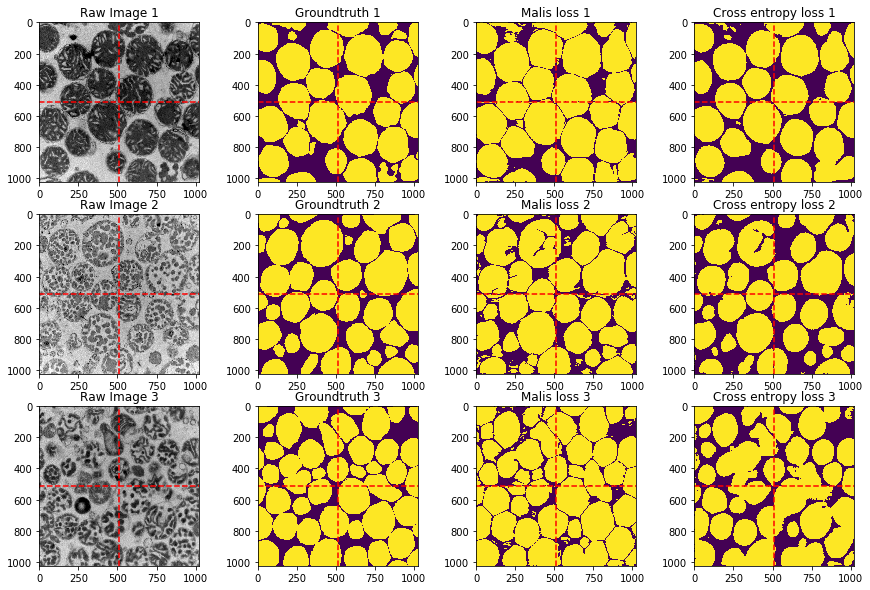

In [9]:
# generating figure

# reconstruct original images (1024,1024,3) from corresponding patches (512,512,3)
# raw data
raw_data = np.zeros((1024,1024,3))
raw_data2 = np.zeros((1024,1024,3))
raw_data3 = np.zeros((1024,1024,3))
k = 0
for i in range(2):
    for j in range(2):
        raw_data[i*512:i*512+512,j*512:j*512+512,:] = raw[k]
        raw_data2[i*512:i*512+512,j*512:j*512+512,:] = raw[k+4]
        raw_data3[i*512:i*512+512,j*512:j*512+512,:] = raw[k+8]
        k+=1
        

# groundtruth
gt_data = np.zeros((1024,1024))
gt_data2 = np.zeros((1024,1024))
gt_data3 = np.zeros((1024,1024))
k = 0
for i in range(2):
    for j in range(2):
        gt_data[i*512:i*512+512,j*512:j*512+512] = gt[k]
        gt_data2[i*512:i*512+512,j*512:j*512+512] = gt[k+4]
        gt_data3[i*512:i*512+512,j*512:j*512+512] = gt[k+8]
        k+=1
gt_data = np.where(gt_data>0,1,0)
gt_data2 = np.where(gt_data2>0,1,0)
gt_data3 = np.where(gt_data3>0,1,0)


# malis loss
malis_data = np.zeros((1024,1024))
malis_data2 = np.zeros((1024,1024))
malis_data3 = np.zeros((1024,1024))
k = 0
for i in range(2):
    for j in range(2):
        malis_data[i*512:i*512+512,j*512:j*512+512] = output_seg[k][:,:,0]
        malis_data2[i*512:i*512+512,j*512:j*512+512] = output_seg[k+4][:,:,0]
        malis_data3[i*512:i*512+512,j*512:j*512+512] = output_seg[k+8][:,:,0]
        k+=1

# cross entropy loss
ce_data = np.zeros((1024,1024))
ce_data2 = np.zeros((1024,1024))
ce_data3 = np.zeros((1024,1024))
k = 0
for i in range(2):
    for j in range(2):
        ce_data[i*512:i*512+512,j*512:j*512+512] = ce[k][:,:,0]
        ce_data2[i*512:i*512+512,j*512:j*512+512] = ce[k+4][:,:,0]
        ce_data3[i*512:i*512+512,j*512:j*512+512] = ce[k+8][:,:,0]
        k+=1

plt.figure(figsize=(15,10))
plt.subplot(3,4,1)
plt.imshow(raw_data)
plt.axhline(y=512,color = 'r',linestyle='--')
plt.axvline(x=512,color = 'r',linestyle='--')
plt.title('Raw Image 1')
plt.subplot(3,4,2)
plt.imshow(gt_data)
plt.axhline(y=512,color = 'r',linestyle='--')
plt.axvline(x=512,color = 'r',linestyle='--')
plt.title('Groundtruth 1')
plt.subplot(3,4,3)
plt.imshow(malis_data)
plt.axhline(y=512,color = 'r',linestyle='--')
plt.axvline(x=512,color = 'r',linestyle='--')
plt.title('Malis loss 1')
plt.subplot(3,4,4)
plt.imshow(ce_data)
plt.axhline(y=512,color = 'r',linestyle='--')
plt.axvline(x=512,color = 'r',linestyle='--')
plt.title('Cross entropy loss 1')

plt.subplot(3,4,5)
plt.imshow(raw_data2)
plt.axhline(y=512,color = 'r',linestyle='--')
plt.axvline(x=512,color = 'r',linestyle='--')
plt.title('Raw Image 2')
plt.subplot(3,4,6)
plt.imshow(gt_data2)
plt.axhline(y=512,color = 'r',linestyle='--')
plt.axvline(x=512,color = 'r',linestyle='--')
plt.title('Groundtruth 2')
plt.subplot(3,4,7)
plt.imshow(malis_data2)
plt.axhline(y=512,color = 'r',linestyle='--')
plt.axvline(x=512,color = 'r',linestyle='--')
plt.title('Malis loss 2')
plt.subplot(3,4,8)
plt.imshow(ce_data2)
plt.axhline(y=512,color = 'r',linestyle='--')
plt.axvline(x=512,color = 'r',linestyle='--')
plt.title('Cross entropy loss 2')

plt.subplot(3,4,9)
plt.imshow(raw_data3)
plt.axhline(y=512,color = 'r',linestyle='--')
plt.axvline(x=512,color = 'r',linestyle='--')
plt.title('Raw Image 3')
plt.subplot(3,4,10)
plt.imshow(gt_data3)
plt.axhline(y=512,color = 'r',linestyle='--')
plt.axvline(x=512,color = 'r',linestyle='--')
plt.title('Groundtruth 3')
plt.subplot(3,4,11)
plt.imshow(malis_data3)
plt.axhline(y=512,color = 'r',linestyle='--')
plt.axvline(x=512,color = 'r',linestyle='--')
plt.title('Malis loss 3')
plt.subplot(3,4,12)
plt.imshow(ce_data3)
plt.axhline(y=512,color = 'r',linestyle='--')
plt.axvline(x=512,color = 'r',linestyle='--')
plt.title('Cross entropy loss 3')
plt.show()
#plt.savefig('result.png')